# Sparkify Churn Prediction
This project intends to use Sparkify user data to identify at-risk users who will likely churn. A small subset(128MB) of the full data (12GB) is used for initial analysis and model development. Once the features and models are selected, the script can be deployed to Spark to build the model on the full dataset.

In [76]:
# Import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression,GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import seaborn as sns

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.

In [3]:
# Read json data
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [4]:
# Print Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Total sessions
print('Total activity records: ',df.count())

Total activity records:  286500


In [6]:
# Get auth summary
df.groupby('auth').agg(F.countDistinct('userId')).show()

+----------+-------------+
|      auth|count(userId)|
+----------+-------------+
|Logged Out|            1|
| Cancelled|           52|
|     Guest|            1|
| Logged In|          225|
+----------+-------------+



In [7]:
# Filter out status Guest and Logged Out to exclude guests
df_clean = df.filter((col('auth') == 'Cancelled') | (col('auth') == 'Logged In'))

In [8]:
# Count User
df_clean.agg(countDistinct('userId')).show()

+-------------+
|count(userId)|
+-------------+
|          225|
+-------------+



In [9]:
df_clean.describe('userId', 'sessionId').show()

+-------+-----------------+------------------+
|summary|           userId|         sessionId|
+-------+-----------------+------------------+
|  count|           278154|            278154|
|   mean|59682.02278593872|1042.5616241362698|
| stddev|109091.9499991047| 726.5010362219813|
|    min|               10|                 1|
|    max|               99|              2474|
+-------+-----------------+------------------+



In [10]:
# Check for nulls
df_clean.filter(df_clean.userId == '').count()

0

In [11]:
df_clean.filter(df_clean.sessionId == '').count()

0

# Exploratory Data Analysis


### Define Churn
During the data cleaning process, we've seen that **Cancelled** status is probably related to churn. for all **225** users in the small dataset, **52** of them have cancelled the service. The overall churn probability is **23.11%**

In [12]:
# Investigate cancellation records
df_clean.filter(df.auth == 'Cancelled').take(1)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18')]

In [13]:
# Get churn 1/0
cancel = udf(lambda auth: 1 if auth == 'Cancelled' else 0, IntegerType())

In [14]:
df_clean = df_clean.withColumn('cancel', cancel('auth'))

In [15]:
# All user activity types
pages = df_clean.groupby('page','method').count().sort('method')
pages.show()

+--------------------+------+------+
|                page|method| count|
+--------------------+------+------+
|               About|   GET|   495|
|            Settings|   GET|  1514|
|                Help|   GET|  1454|
|           Downgrade|   GET|  2055|
|             Upgrade|   GET|   499|
|               Error|   GET|   252|
|Cancellation Conf...|   GET|    52|
|                Home|   GET| 10082|
|         Roll Advert|   GET|  3933|
|          Add Friend|   PUT|  4277|
|              Logout|   PUT|  3226|
|              Cancel|   PUT|    52|
|      Submit Upgrade|   PUT|   159|
|     Add to Playlist|   PUT|  6526|
|    Submit Downgrade|   PUT|    63|
|       Save Settings|   PUT|   310|
|         Thumbs Down|   PUT|  2546|
|            NextSong|   PUT|228108|
|           Thumbs Up|   PUT| 12551|
+--------------------+------+------+



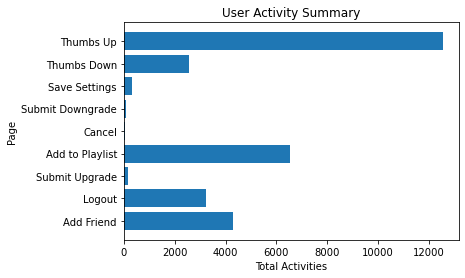

In [16]:
# Use'PUT' to get user proactive activities
pages_df = pages.toPandas()
pages_df_plt = pages_df.loc[(pages_df['method'] == 'PUT') & (pages_df['page'] != 'NextSong')]

activity = pages_df_plt['page']
count = pages_df_plt['count']

plt.barh(activity, count)
plt.ylabel('Page')
plt.xlabel('Total Activities')
plt.title('User Activity Summary')

plt.show()

In [17]:
# Example of user downgrade
# Downgrade happens right after user submit downgrade
df_clean.filter(col('userId') == '131').groupby(['level','sessionId','page']\
                                         ).agg(min(col('ts')).alias('ts'),\
                                              sum(col('length')).alias('length')).sort(col('ts').desc()).show(30)

+-----+---------+----------------+-------------+------------------+
|level|sessionId|            page|           ts|            length|
+-----+---------+----------------+-------------+------------------+
| free|     2281|            Home|1543548083000|              null|
| free|     2155|      Add Friend|1543120417000|              null|
| free|     2155|     Thumbs Down|1543117205000|              null|
| free|     2155|            Home|1543114842000|              null|
| free|     2155|          Logout|1543114535000|              null|
| free|     2155|     Roll Advert|1543114106000|              null|
| free|     2155|       Thumbs Up|1543111791000|              null|
| free|     2155|           About|1543110822000|              null|
| free|     2155| Add to Playlist|1543109614000|              null|
| free|     2155|        NextSong|1543109551000|11182.815799999997|
| free|     2094|        NextSong|1542799890000|         563.35582|
| free|     2094|            Home|1542799886000|

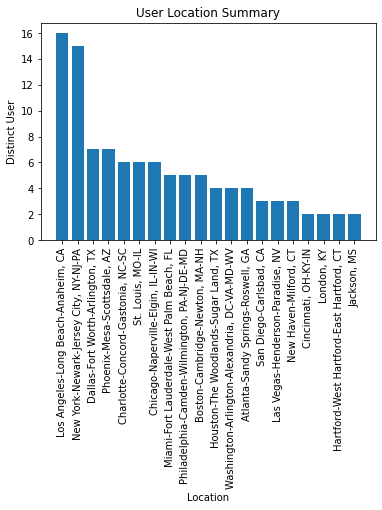

In [18]:
# Get user location
df_loc = df_clean.groupby('location').agg(countDistinct('userId')).toPandas()
df_loc = df_loc.sort_values('count(userId)', ascending = False).iloc[:20,:]

plt.bar(df_loc['location'], df_loc['count(userId)'])
plt.ylabel('Distinct User')
plt.xlabel('Location')
plt.title('User Location Summary')
plt.xticks(rotation='vertical')

plt.show()

# Feature Engineering

In [19]:
# Convert ts to date
df_feat = df_clean.withColumn("date", F.to_date(F.from_unixtime(col('ts')/lit(1000))))
df_feat.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', cancel=0, date=datetime.date(2018, 9, 30))]

In [20]:
# Get date range
df_feat.select('date').agg(min('date')).show()

+----------+
| min(date)|
+----------+
|2018-09-30|
+----------+



In [21]:
df_feat.select('date').agg(max('date')).show()

+----------+
| max(date)|
+----------+
|2018-12-02|
+----------+



In [22]:
# Get user activity summary over time
time = df_feat.select(['date','sessionId','userId','level','song']\
                      ).groupby(['date','level']).agg(F.count(col('sessionId')), F.countDistinct(col('userId')),\
                                                      F.count(col('song')))

In [23]:
# Export to pandas for visualization
df_time = time.toPandas()
df_time.head()

,date,level,count(sessionId),count(userId),count(song)
0,2018-11-25,paid,2582,27,2143
1,2018-10-27,free,433,11,342
2,2018-10-24,paid,4452,43,3747
3,2018-10-20,paid,4572,31,3830
4,2018-10-20,free,610,15,452


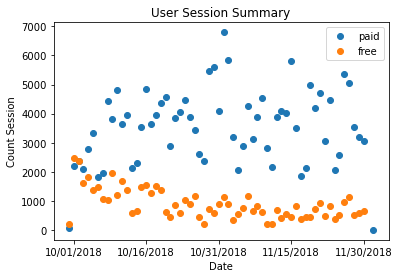

In [24]:
# Count session over time
date = df_time['date']
count = df_time['count(sessionId)']

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

# beautifying the labels
plt.plot_date(df_time['date'][df_time.level == "paid"], df_time['count(sessionId)'][df_time.level == "paid"], label = 'paid')
plt.plot_date(df_time['date'][df_time.level == "free"], df_time['count(sessionId)'][df_time.level == "free"], label = 'free')
plt.legend()
plt.ylabel('Count Session')
plt.xlabel('Date')
plt.title('User Session Summary')
plt.show()

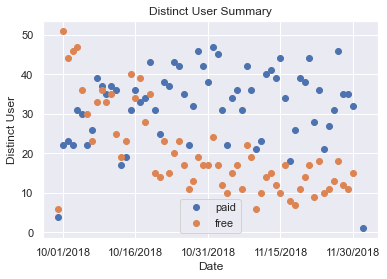

In [77]:
# Count user over time
date = df_time['date']
count = df_time['count(userId)']

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

plt.plot_date(df_time['date'][df_time.level == "paid"], count[df_time.level == "paid"], label = 'paid')
plt.plot_date(df_time['date'][df_time.level == "free"], count[df_time.level == "free"], label = 'free')
plt.ylabel('Distinct User')
plt.xlabel('Date')
plt.title('Distinct User Summary')
plt.legend()
plt.show()

From the dataset, the number of free users and free usersessions decreases over time.

In [26]:
# User registration date
df_feat = df_feat.withColumn('date_created', F.to_date(F.from_unixtime(col('registration')/lit(1000))))

In [27]:
# Get user age at the activity date
df_feat = df_feat.withColumn('user_age',F.datediff(col('date'),col('date_created')))

In [28]:
df_feat.describe('user_age').show()

+-------+------------------+
|summary|          user_age|
+-------+------------------+
|  count|            278154|
|   mean| 64.75977695808797|
| stddev|42.019723870983626|
|    min|                -2|
|    max|               256|
+-------+------------------+



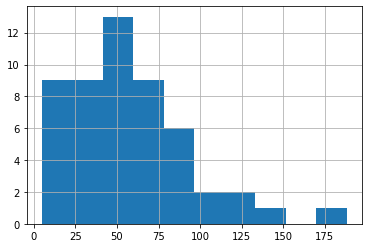

In [29]:
#User cancel by age
df_cancelled = df_feat.filter(col('cancel') == 1).select(['date','user_age','level']).toPandas()

df_cancelled['user_age'].hist()

In [30]:
# Get user interactions except for playing songs
inter = ['Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend']
get_interactions = udf(lambda x: 1 if x in inter else 0, IntegerType())

# Get negative feedback from user
thumbs_down = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())

df_feat = df_feat.withColumn('interactions', get_interactions('page'))
df_feat = df_feat.withColumn('thumbs_down', thumbs_down('page'))

In [31]:
# Get number of songs played
songs = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
df_feat = df_feat.withColumn('songs', songs('page'))

In [32]:
# Has the user ever used paied service
paid_hist = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df_feat = df_feat.withColumn('paid_hist', paid_hist('level'))

# Has the user ever downgraded
downgrade = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
df_feat = df_feat.withColumn('downgraded', downgrade('page'))

In [33]:
# Convert gender to 1/0. 1 = female
female = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df_feat = df_feat.withColumn('female', female('gender'))

In [34]:
# Get user level dimensions
dims = df_feat.groupby('userId','female','date_created').agg(\
                                                          max('user_age').alias('user_age'),\
                                                          max('paid_hist').alias('paid_user'),\
                                                          max('downgraded').alias('downgraded'),\
                                                          max('cancel').alias('canceled'))

In [35]:
# Inspect Dimensions
dims.take(1)

[Row(userId='142', female=0, date_created=datetime.date(2018, 9, 28), user_age=63, paid_user=1, downgraded=0, canceled=0)]

In [36]:
# Get measures based on usersessions and interactions
measures = df_feat.groupby('userId','sessionId').agg(\
                                                          min('date').alias('start_date'),\
                                                          max('date').alias('end_date'),\
                                                          sum('interactions').alias('interactions'),\
                                                          sum('thumbs_down').alias('thumbs_down'),\
                                                          sum('songs').alias('songs'),\
                                                          sum('length').alias('length'),\
                                                          countDistinct('artist').alias('c_artist'))

In [37]:
# Get the date gap between sessions
measures_lag = measures.withColumn('prev_end_date',
                        F.lag(col('end_date')).over(Window.partitionBy('userID').orderBy('start_date')))

measures_lag = measures_lag.withColumn('session_gap',\
                                      F.datediff(col('start_date'),col('prev_end_date')))

measures_agg = measures_lag.groupby('userId').agg(\
                                                 F.count('sessionId').alias('total_session'),\
                                                 avg('interactions').alias('interactions'),\
                                                 avg('thumbs_down').alias('thumbs_down'),\
                                                 avg('songs').alias('songs'),\
                                                 avg('length').alias('length'),\
                                                 avg('c_artist').alias('artists'),\
                                                 avg('session_gap').alias('session_gap'))

In [38]:
# Inspect measures
measures_agg.take(1)

[Row(userId='100010', total_session=7, interactions=4.714285714285714, thumbs_down=2.4285714285714284, songs=39.285714285714285, length=9562.985335714286, artists=38.57142857142857, session_gap=7.166666666666667)]

In [39]:
# Inspect dim and measure shape
print('dim: ',dims.count(),' measure: ',measures_agg.count())

dim:  225  measure:  225


In [40]:
# Join dims and measures
output = dims.join(measures_agg, on = 'userId')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024BD6E384F0>,
      dtype=object)

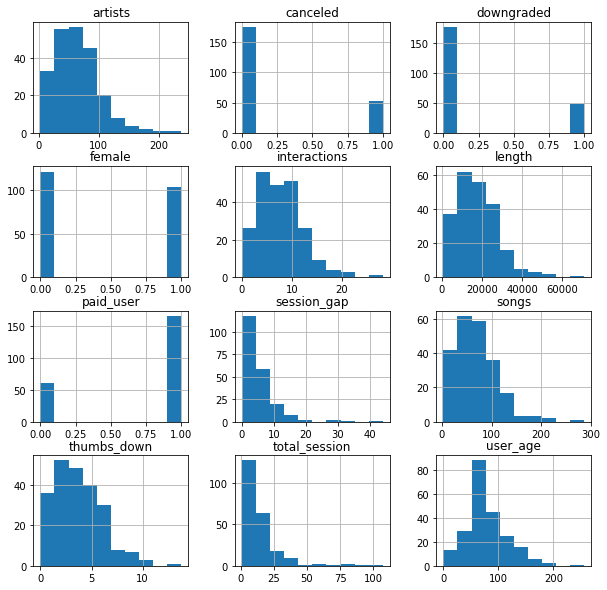

In [41]:
# Inspect aggregated data
model_df = output.toPandas()

model_df.hist(figsize = (10,10))

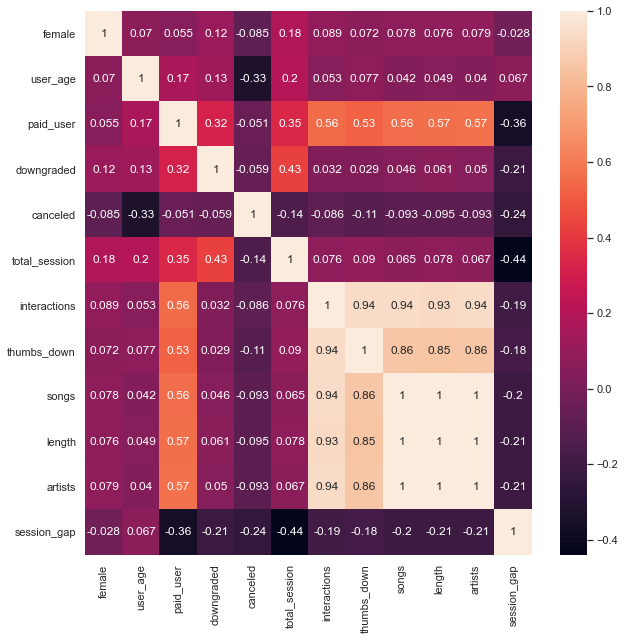

In [42]:
# Get correlations
sns.set(rc={'figure.figsize':(10,10)},font_scale=1)
sns.heatmap(model_df.corr(), annot=True)

From histogram and correlation matrix, **songs**, **length** and **artists** are very similar. We will only include **length** in the model as it has the highest correlation with **cancelled**

# Modeling

In [43]:
# Inspect aggregated data
model_df.loc[model_df.isnull().sum(axis = 1) > 0]

,userId,female,date_created,user_age,paid_user,downgraded,canceled,total_session,interactions,thumbs_down,songs,length,artists,session_gap
2,125,0,2018-08-01,71,0,0,1,1,0.0,0.0,8.0,2089.11310,8.0,NaN
29,133,0,2018-09-05,39,0,0,0,1,6.0,2.0,32.0,8029.16428,32.0,NaN
56,300007,0,2018-09-23,11,1,0,1,1,20.0,11.0,111.0,28028.71048,107.0,NaN
60,100006,1,2018-09-26,9,0,0,1,1,9.0,2.0,26.0,5854.89105,26.0,NaN
97,19,1,2018-09-18,22,1,0,0,1,19.0,5.0,216.0,54480.93387,197.0,NaN
99,300024,1,2018-09-10,39,1,0,0,1,10.0,6.0,88.0,22698.64417,85.0,NaN
118,135,1,2018-07-24,72,0,0,0,1,0.0,0.0,6.0,1596.44461,6.0,NaN
119,156,0,2018-11-26,0,0,0,0,1,0.0,0.0,3.0,691.66884,3.0,NaN
121,100024,0,2018-09-07,27,0,0,1,1,5.0,5.0,22.0,5160.53207,22.0,NaN
135,100011,0,2018-09-26,5,0,0,1,1,3.0,0.0,11.0,2841.69950,11.0,NaN


Total session = 1： Either the user is new or they have been dormant since registration. Although the secend type is very likely 'churned', it is different from the churn we are trying to predict here (people who used to be an active user but decides to leave). Therefore we will exclude them from the prediction

In [44]:
# Assemble num features
assembler = VectorAssembler(inputCols=['female','user_age','paid_user',\
                                       'downgraded','total_session','interactions',\
                                      'thumbs_down','length','session_gap'],\
                            outputCol='NumFeatures',handleInvalid = 'skip')
data = assembler.transform(output)

In [45]:
# Use 'canceled' as model prediction label
data = data.withColumnRenamed('canceled','label')

In [46]:
# Split train/test data
test, validation = data.randomSplit([0.8, 0.2], seed=42)

In [47]:
# Standard Scaler
standardscaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withMean=True, withStd=True)

# Evaluators from pyspark mllib
lr = LogisticRegression(maxIter=10, regParam=0.0)
gbt = GBTClassifier(maxIter=5, maxDepth=2)
lsvc = LinearSVC(maxIter=10, regParam=0.1)
rf = RandomForestClassifier()

In [48]:
def fit_model(model, paramGrid = None):
    # Model fitting with selected model and paramgric(optional)
    # Input: model, paramgrid
    # Output: fitted model, prediction on validation set
    pipeline = Pipeline(stages=[standardscaler, model])
    
    if paramGrid != None:
        crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
        fitmodel = crossval.fit(test)
    else:
        fitmodel = pipeline.fit(test)
    
    results = fitmodel.transform(validation)
    
    return fitmodel, results

In [49]:
# Evaluate the model on validation set
def val_evaluation(results):
    # Input: prediction results
    # Output: accuracy, precision and recall score
    predictionAndLabels = results.select(['prediction', 'label']\
                                      ).withColumn('label',col('label').cast(DoubleType())).rdd

    metrics = MulticlassMetrics(predictionAndLabels)
    cm=metrics.confusionMatrix().toArray()
    
    # Use confusion matrix to calculate evaluation metrics
    # accuracy: (TP+TN)/Total Predictions
    # precision: TP/(TP + FP)
    # recall: TP/(TP + FN)
    # f1 score: 2*(Recall * Precision) / (Recall + Precision)
    accuracy=(cm[0][0]+cm[1][1])/cm.sum()
    precision=(cm[1][1])/(cm[0][1]+cm[1][1])
    recall=(cm[1][1])/(cm[1][0]+cm[1][1])
    f1 = MulticlassClassificationEvaluator().evaluate(results)
    return(round(f1,2), round(accuracy,2),round(precision,2),round(recall,2))

In [50]:
# Fit models ane print results
lrmodel, lrresults = fit_model(lr)

In [51]:
rfmodel, rfresults = fit_model(rf)

In [52]:
lsvcmodel, lsvcresults = fit_model(lsvc)

In [53]:
gbtmodel, gbtresults = fit_model(gbt)

In [54]:
print("LogisticRegression: f1_score, accuracy,precision,recall", val_evaluation(lrresults))
print("RandomForest: f1_score,accuracy,precision,recall", val_evaluation(rfresults))
with np.errstate(divide='ignore', invalid='ignore'):
    print("LSVC: f1_score,accuracy,precision,recall", val_evaluation(lsvcresults))
print("GBT: f1_score,accuracy,precision,recall", val_evaluation(gbtresults))

LogisticRegression: f1_score, accuracy,precision,recall (0.83, 0.85, 1.0, 0.44)
RandomForest: f1_score,accuracy,precision,recall (0.73, 0.79, 1.0, 0.22)
LSVC: f1_score,accuracy,precision,recall (0.61, 0.73, nan, 0.0)
GBT: f1_score,accuracy,precision,recall (0.68, 0.76, 1.0, 0.11)


LogisticRegression has the best performance with F-score at 0.83.

Random Forest is also performing well with 0.73 F-score. Since rf have stronger prediction power in large datasets, Random Forest will be trained and tuned with full data as well

LSVC does not work well on this data set, as the **recall** is 0 which means it is not able to identify any churn. Gradient Boost Tree has slightly better f-score than LSVC but also has low recall issue


### Logistic Regression Tuning
- Investigate the coefficients
- Look for best threshold
- Apply weights to unbalanced data

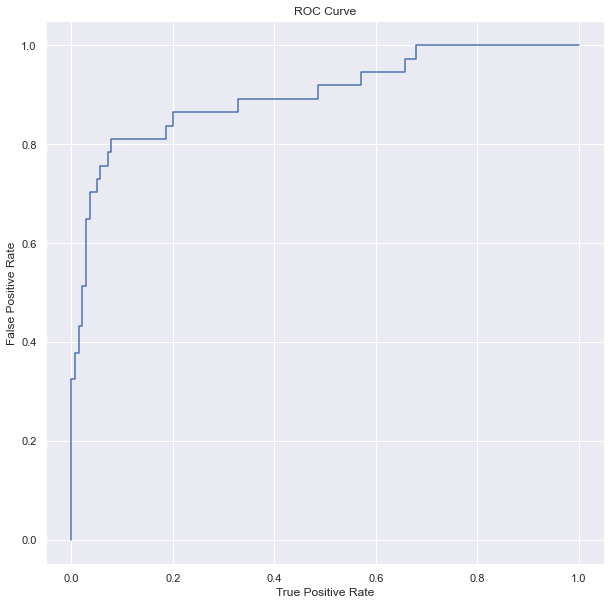

Training set areaUnderROC: 0.9003861003861006


In [55]:
# lr model ROC curve
trainingSummary = lrmodel.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [56]:
# Extract feature names from the original data
dict_feats = data.schema['NumFeatures'].metadata['ml_attr']['attrs']['numeric']
list_feats = np.array([x['name'] for x in dict_feats])

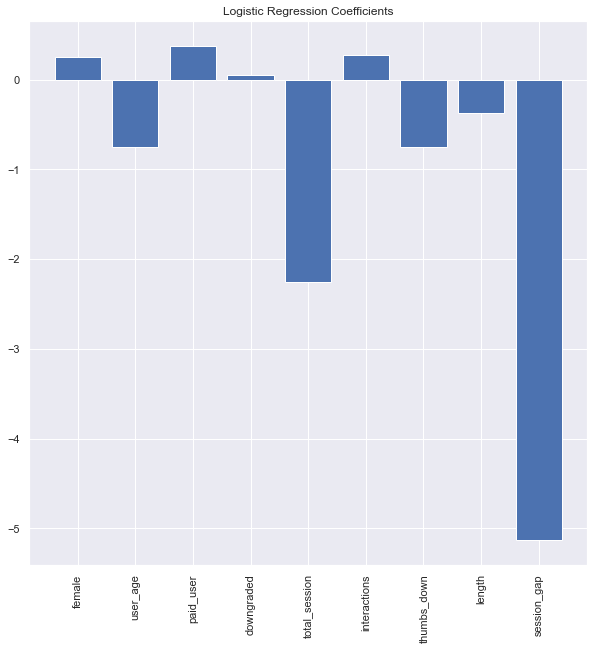

In [57]:
# Get coefficients
lr_corr = lrmodel.stages[-1].coefficients
plt.bar(list_feats,lr_corr)
plt.xticks(rotation='vertical')
plt.title('Logistic Regression Coefficients')
plt.show()

In [58]:
# Get best threshold for current lr model
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

In [59]:
bestThreshold

0.26956170807110974

In [60]:
# Try weighted col since the cancelled outcome is unbalanced
balancingRatio = data.filter(col('label') == 1).count() / data.count()
calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())

weightedDataset = data.withColumn("classWeightCol", calculateWeights('label'))

In [61]:
weightedDataset.groupby('classWeightCol').count().show()

+-------------------+-----+
|     classWeightCol|count|
+-------------------+-----+
|0.21904761904761905|  164|
|  0.780952380952381|   46|
+-------------------+-----+



In [62]:
test, validation = weightedDataset.randomSplit([0.8, 0.2], seed=42)

lrweightedmodel, lrweightedresults = fit_model(lr.setWeightCol('classWeightCol'))
print("LogisticRegression with weight: f1 score,accuracy,precision,recall", val_evaluation(lrweightedresults))

LogisticRegression with weight: f1 score,accuracy,precision,recall (0.85, 0.85, 0.75, 0.67)


### Random Forest Tuning
- Investigate feature importance

In [63]:
# Extract feature importance from rfmodel
featImportances = np.array(rfmodel.stages[-1].featureImportances)

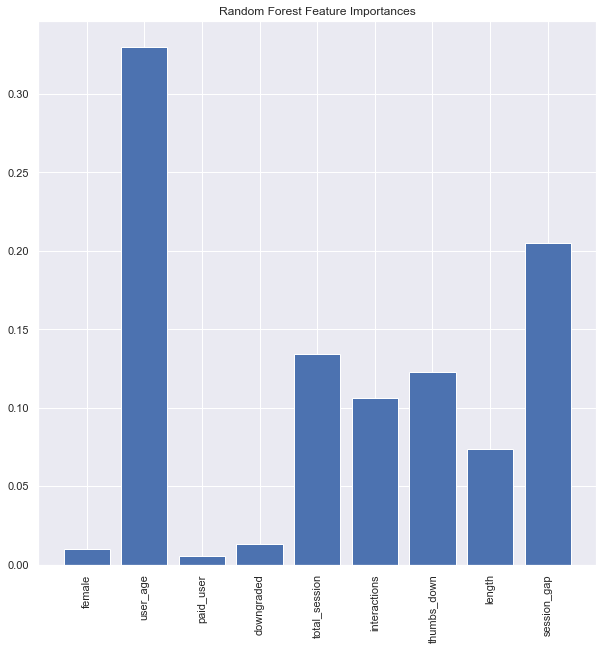

In [64]:
plt.bar(list_feats,featImportances)
plt.xticks(rotation='vertical')
plt.title('Random Forest Feature Importances')
plt.show()

Code prep for Grid Search

In [65]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1])\
    .addGrid(lr.threshold,[0.3,0.4,0.5])\
    .build()

In [67]:
# lrbest, lrresults = fit_model(lr, paramGrid = paramGrid)

In [1]:
# print best model params
# bp_index = lrbest.avgMetrics.index(np.max(lrbest.avgMetrics))
# bp = paramGrid[bp_index]
# print(bp)